In [48]:
# dependencies (numpy, matplotlib, and keras)
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from keras.layers import Input, Dense, Lambda, MaxPooling2D, Conv2D,Conv1D, Flatten
from keras.models import Model,Sequential
from keras import backend as K
from keras import objectives
from keras.layers.core import Dense, Dropout, Activation
from keras.datasets import mnist
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

In [107]:
input_shape = 784
batch_size = 100
hidden_dim = 128
features = 5
nb_epoch = 5

#Encoder Begin
X_input = Input(batch_shape = (batch_size,input_shape))
hidden = Dense(hidden_dim, activation='relu')(X_input)

#Begin the Squeeze
mean = Dense(features,name='Mean')
Z_mean = mean(hidden)
variance = Dense(features,name='Variance')
Z_variance = variance(hidden)



In [108]:
#Begin the Sampling function
def sample(args):
    Z_mean, Z_var = args
    epsilon = K.random_normal(shape=(batch_size, features), mean=0.)
    return Z_mean + K.exp(Z_variance / 2) * epsilon
#Wrapping into a tensor shape
Z = Lambda(sample, output_shape=(features,),name="Z_Sampling")([Z_mean, Z_variance])

In [109]:
#Decoder begin
dec_hidden = Dense(hidden_dim, activation = 'relu')
decoder_hidden = dec_hidden(Z)
dec_X = Dense(input_shape, activation = 'sigmoid')
decoder_X = dec_X(decoder_hidden)

#loss
def vae_loss(X_input, decoder_X):
    xent_loss = input_shape * objectives.binary_crossentropy(X_input, decoder_X)
    kl_loss = - 0.5 * K.sum(1 + Z_variance - K.square(Z_mean) - K.exp(Z_variance), axis=-1)
    return xent_loss + kl_loss

vae = Model(X_input, decoder_X)
vae.compile(optimizer='rmsprop', loss=vae_loss)

In [110]:
#Train
# train the VAE on MNIST digits
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
print(x_train.shape)
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)


vae.fit(x_train, x_train,
        shuffle=True,
        nb_epoch=nb_epoch,
        batch_size=batch_size,
        validation_data=(x_test, x_test),verbose=1)

(60000, 28, 28)
(60000, 784)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:17: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 6s 106us/step - loss: 173.6553 - val_loss: 147.1264
Epoch 2/5
60000/60000 [==============================] - 6s 92us/step - loss: 144.0374 - val_loss: 140.4195
Epoch 3/5
60000/60000 [==============================] - 5s 83us/step - loss: 139.4222 - val_loss: 137.4268
Epoch 4/5
60000/60000 [==============================] - 5s 84us/step - loss: 136.9686 - val_loss: 135.1074
Epoch 5/5
60000/60000 [==============================] - 5s 83us/step - loss: 135.3949 - val_loss: 134.0683


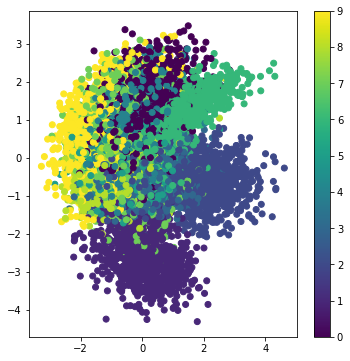

In [111]:
#plot latent/hidden space

# build a model to project inputs on the latent space
encoder = Model(X_input, Z)

# display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test,cmap="viridis")
plt.colorbar()
plt.show()

ValueError: Error when checking input: expected input_6 to have shape (5,) but got array with shape (2,)

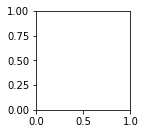

In [112]:
decodeInp = Input(shape = (features,))
decodeInp2 = dec_hidden(decodeInp)
decodeInp3 = dec_X(decodeInp2)
decodee = Model(decodeInp, decodeInp3)
encodedImg = encoder.predict(x_test, batch_size=batch_size)
decodedImg = decodee.predict(encodedImg, batch_size=batch_size)


grid_x = norm.ppf(np.linspace(0.05, 0.95, 15))
grid_y = norm.ppf(np.linspace(0.05, 0.95, 15))

n = 15
k = 0
plt.figure(figsize=(30,4))
for i,xval in enumerate(grid_x):
    for j,yval in enumerate(grid_y):
        ax = plt.subplot(2, n, k+1)
        f = np.array([[xval,yval]])
        f = decodee.predict(f)
        plt.imshow(f.reshape((28,28)),cmap='viridis')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        k+=1
#         print(i)
        
        if(k==30):
            break
    if(k==30):
        break

In [113]:
y_train = np_utils.to_categorical(y_train, 10)
train_x, test_x, train_y, test_y = train_test_split(x_train, y_train, test_size=0.2)

In [114]:
encodedX = encoder.predict(train_x, batch_size=batch_size)

In [115]:
encodedX.shape

(48000, 5)

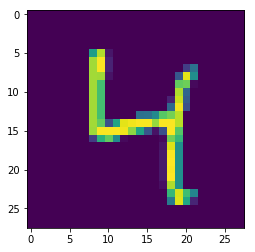

4


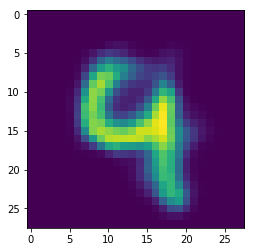

In [119]:
num = 666
plt.imshow(train_x[num].reshape(28,28))
plt.show()

hi = np.array([encodedX[num]])
prediction = decodee.predict(hi)
plt.imshow(prediction.reshape((28,28)))
print(np.argmax(train_y[num]))

In [105]:
testing = encodedX
testing = testing.reshape(1,1)
# train_x.shape
testing.shape

ValueError: cannot reshape array of size 96000 into shape (1,1)

In [120]:
#BEGIN FFNN

model = Sequential()
model.add(Dense(512, input_shape=(features,)))
model.add(Activation('relu'))                            
model.add(Dropout(0.2))

# model.add(Dense(256))
# model.add(Activation('relu'))
model.add(Dense(512))
model.add(Activation('relu'))
# model.add(Dropout(0.2))

model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')
# model.summary()


model.fit(encodedX, train_y,
          batch_size=batch_size, epochs=20)

Epoch 1/20
48000/48000 [==============================] - 5s 111us/step - loss: 0.5624 - acc: 0.8035
Epoch 2/20
48000/48000 [==============================] - 4s 89us/step - loss: 0.4647 - acc: 0.8340
Epoch 3/20
48000/48000 [==============================] - 4s 91us/step - loss: 0.4497 - acc: 0.8399
Epoch 4/20
48000/48000 [==============================] - 4s 88us/step - loss: 0.4408 - acc: 0.8434
Epoch 5/20
48000/48000 [==============================] - 4s 88us/step - loss: 0.4333 - acc: 0.8443
Epoch 6/20
48000/48000 [==============================] - 4s 88us/step - loss: 0.4307 - acc: 0.8452
Epoch 7/20
48000/48000 [==============================] - 4s 88us/step - loss: 0.4243 - acc: 0.8477
Epoch 8/20
48000/48000 [==============================] - 4s 88us/step - loss: 0.4222 - acc: 0.8479
Epoch 9/20
48000/48000 [==============================] - 4s 88us/step - loss: 0.4201 - acc: 0.8472
Epoch 10/20
48000/48000 [==============================] - 4s 91us/step - loss: 0.4178 - acc: 0.849

0


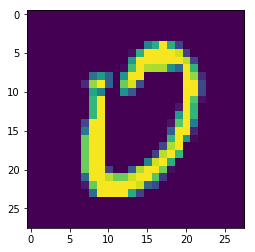

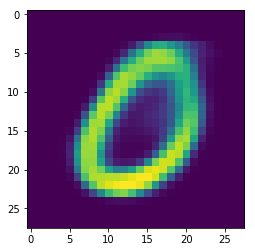

1


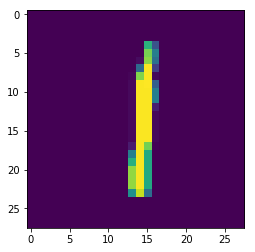

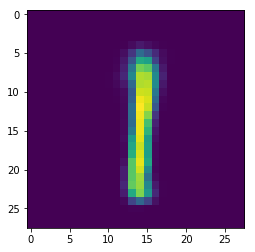

2


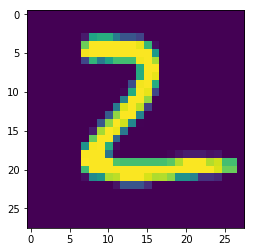

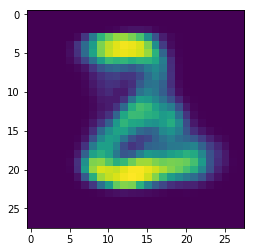

2


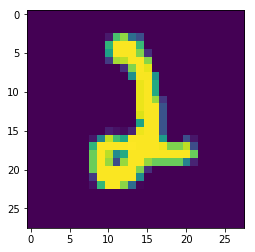

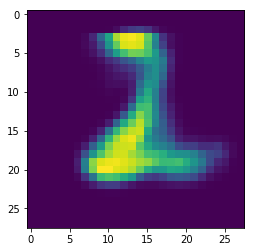

4


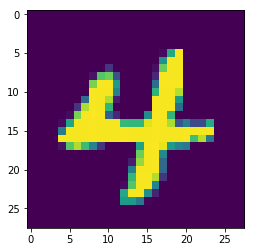

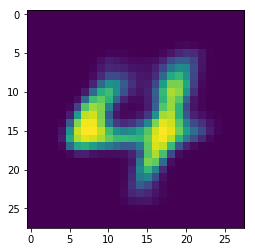

8


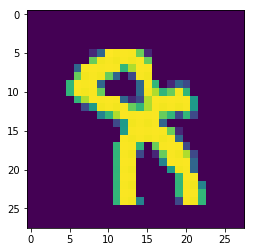

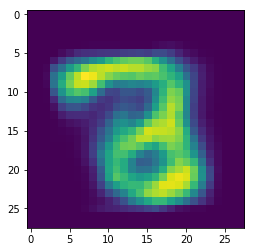

6


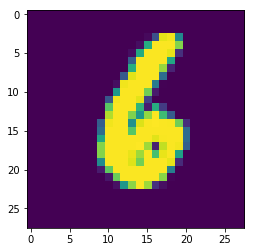

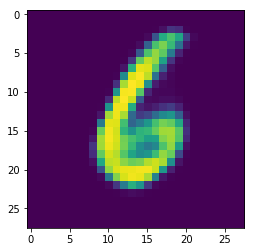

5


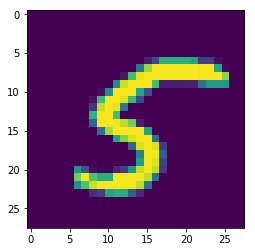

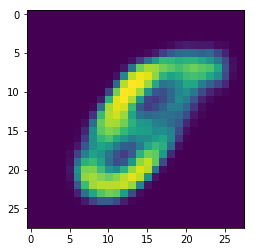

9


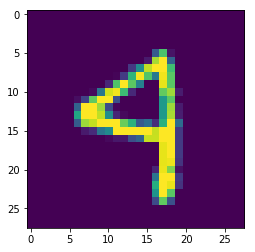

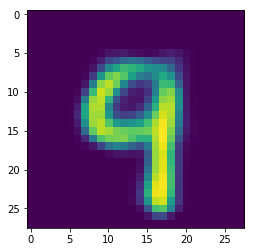

9


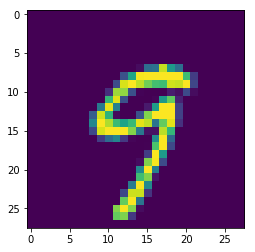

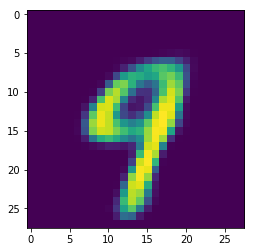

In [134]:
for i in range(0,10):
    
    num = i
    hi = np.array([encodedX[num]])
    prediction = model.predict(hi)
    print(np.argmax(prediction))
    plt.imshow(train_x[num].reshape((28,28)),cmap='viridis')
    plt.show()
    hello = decodee.predict(np.array([encodedX[num]]))
    plt.imshow(hello.reshape((28,28)),cmap='viridis')
    plt.show()